# About
[Purpose for this notebook]

Bi-LSTMs are a type of RNNs, and as such, have memory which can store temporal information available in time series data. 

# Bidirectional LSTM

# Global parameters

In [1]:
name_prefix = "Multivariate-Bi-LSTM"

# Libraries

In [2]:
%run "/home/cesar/Python_NBs/HDL_Project/HDL_Project/global_fv.ipynb"

In [3]:
import os
import glob
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Data
from sklearn.model_selection import train_test_split

# DL Model
from keras.models import Sequential
from keras.layers import LSTM, Dense, Bidirectional

# Optimizer
from tensorflow.keras.optimizers import Adam

# Plotting
import matplotlib.pyplot as plt

# Early stopping
from tensorflow.keras.callbacks import EarlyStopping

# Checkpoint
from keras.callbacks import ModelCheckpoint

# User-Defined Functions

In [4]:
def design_model(n_steps, lr, n_features):
    """
    n_steps: Number of steps
    n_features: Number of features
    lr: Learning rate
    """
    model = Sequential(name = "Multivariate-Bidirectional-LSTM-model")
    
    # Number of neurons (nodes) are just about greater than the number of features.
    # Rule of thumb is for number of neurons to be about 2/3 of the input    
    num_neurons = int(np.ceil(n_features *2 /3))
    
    # It'd be best for the number of neurons to be in the scale of 2^n for computational purposes.
    if(False):
        while num_neurons > 2**i:
            i += 1

        num_neurons = 2**i   
    
    # Bidirectional LSTM layer
    model.add(Bidirectional(LSTM(num_neurons, activation= 'relu' ), input_shape=(n_steps, n_features)))
    
    # Output layer with one neuron to a model instance (to return one output)
    model.add(Dense(1, kernel_initializer='normal',activation='linear'))
    # Regularization prevents the learning process to completely fit the model to the training data which can lead to overfitting.
    # The most common regularization method is dropout.
    #model.add(layers.Dropout(0.1))    
    
    # Optimizer
    opt = Adam(learning_rate=lr)
    model.compile(optimizer=opt,  metrics=['mae'], loss= 'mse')
    
    return model

In [5]:
def fit_model_es_checkpoint(X, y, learning_rate, num_epochs, bs, model):
    checkpoint_name = 'Trained_Models/U_Weights_Multi-Bi-LSTM_-{val_loss:.5f}--{epoch:03d}.hdf5'
    
    early_stopping_callback = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=15)
    checkpoint_callback = ModelCheckpoint(checkpoint_name, monitor='mae', verbose=0, save_best_only=True, mode='min')
    history = model.fit(X, y, epochs=num_epochs, batch_size=bs, validation_split = 0.25, verbose = 0, shuffle = False, callbacks=[early_stopping_callback, checkpoint_callback])
    return history

# Data

## Parameters

In [6]:
sql_table = "sima_station_CE"
target = "pm25"

# Define columns of interest from sql table
#     Select all columns:
column = "*"
#     Select specific columns:
#column = "datetime, prs, rainf, rh, sr, tout, wdr, wsr, " + str(target)

# Filter data with WHERE command
sql_where = "where datetime >= \'2021-03-01\'"

# Number of time steps per sample
n_steps = 24

## Creating samples

In [7]:
# Initialize class to create multivariate samples:
multi_ts = multivariate_samples(sql_table, target, column, sql_where)

X, y = multi_ts.samples_creation(n_steps, target)
X = np.asarray(X)
y = np.asarray(y)

# Understanding the three-dimensional structure of the input samples
print(np.shape(X))
print()
print("* The 1st dimension is the number of samples, in this case: {}".format(np.shape(X)[0])) 
print("* The 2nd dimension is the number of time steps per sample, in this case {}, the value specified to the function.".format(np.shape(X)[1]))
print("* The 3rd dimension specifies the number of parallel time series —or the number of variables— in this case {}.".format(np.shape(X)[2]))

(9889, 24, 13)

* The 1st dimension is the number of samples, in this case: 9889
* The 2nd dimension is the number of time steps per sample, in this case 24, the value specified to the function.
* The 3rd dimension specifies the number of parallel time series —or the number of variables— in this case 13.


In [8]:
# Number of features
n_features = np.shape(X)[2]

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, shuffle= False)

# Data model: Bi-LSTM

In [10]:
learning_rate = 0.01

# Maximum number of epochs
num_epochs = 100

#fixed learning rate value
learning_rate = 0.01

#fixed number of batches
batch_size = 7

In [11]:
model = design_model(n_steps, learning_rate, n_features)
model.summary()

Model: "Multivariate-Bidirectional-LSTM-model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 18)               1656      
 l)                                                              
                                                                 
 dense (Dense)               (None, 1)                 19        
                                                                 
Total params: 1,675
Trainable params: 1,675
Non-trainable params: 0
_________________________________________________________________


Elapsed time is 302.748052 seconds.


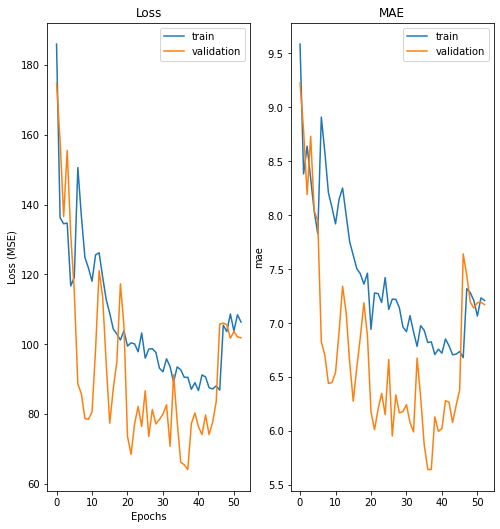

Min training Loss: 86.71392059326172
Min validation Loss:  64.07315063476562

Final training Loss: 106.34207153320312
Final validation Loss: 101.8271255493164

Min training MAE: 6.680355548858643
Min validation MAE:  5.643372058868408

Final training MAE: 7.2096333503723145
Final validation MAE: 7.171492099761963


In [12]:
# Train
#Training with early stopping

t.tic() #Start timer
history = fit_model_es_checkpoint(X_train, y_train, learning_rate, num_epochs, batch_size, model)
t.toc() #Time elapsed since t.tic()

# Visualization
train_val_plot(history)

# Testing the model
As long as two models share the same architecture you can share weights between them. So, when restoring a model from weights-only, create a model with the same architecture as the original model and then set its weights.

In [11]:
# Define the model
model = design_model(n_steps, learning_rate, n_features)
model.summary()

Model: "Multivariate-Bidirectional-LSTM-model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 18)               1656      
 l)                                                              
                                                                 
 dense (Dense)               (None, 1)                 19        
                                                                 
Total params: 1,675
Trainable params: 1,675
Non-trainable params: 0
_________________________________________________________________


In [22]:
folder_models = "Trained_Models"
file_path = str(os.getcwd()) + "/" + folder_models 
file_pre = "/U_Weights_Multi-Bi-LSTM*"

weights_files = list(glob.glob(file_path + file_pre))
weights_files.sort(reverse = True)

weights_files = [f[len(file_path)+1:] for f in weights_files]

In [25]:
print("Loaded file:", weights_files[0])

# Choosing the best checkpoint (lowest error)
weights_file = "Trained_Models/U_Weights_Multi-Bi-LSTM_-70.74516--033.hdf5" # folder_models + "/" + weights_files[0] 

# Loading it
model.load_weights(weights_file) 

Loaded file: U_Weights_Multi-Bi-LSTM_-94.95815--018.hdf5


In [26]:
tmp_df = pd.DataFrame(testing_evaluation(X_test, y_test, model), index=[0])
tmp_df.insert(0, "Model", name_prefix.replace("-", " "), True)
tmp_df

,Model,RMSE,MAE,MAPE,R^2,Max Error
0,Multivariate Bi LSTM,14.885752,10.389327,3.653478e+15,0.26111,82.879968


# Sources
* https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit
* https://www.tensorflow.org/tutorials/keras/save_and_load